# Programa Ingenias+ Data Science

## Objetivo del notebook

El objetivo de este notebook es aplicar y comparar técnicas de aprendizaje no supervisado, tanto de clustering como de reducción de dimensionalidad, para identificar patrones y estructuras subyacentes en los datos.

Las columnas de características que se utilizarán en el notebook se detallan a continuación.


## Importación de archivos y librerías

In [1]:
# Imports de librerías y funciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, pairwise_distances, silhouette_score, silhouette_samples
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import time
import prince
from itertools import product

from utils.codificaciones import *
from utils.funcions import *

In [2]:
# Importar el csv
friesgo_raw = pd.read_csv('datasets/friesgo_analisis.csv')

In [3]:
friesgo_raw.shape

(29224, 43)

## Preprocesado

### Identificación de variables

In [4]:
# Copiar el dataframe
friesgo_cod = friesgo_raw.copy()

In [5]:
# Filas y columnas
friesgo_cod.shape

(29224, 43)

In [6]:
# Columnas presentes
friesgo_cod.columns

Index(['cant_tipos_tabaco', 'es_diabetico', 'cod_provincia',
       'ansiedad_depresion', 'fumado_100_cigarrillos',
       'af_intensa_veces_por_semana', 'tiempo_sentado_min_por_dia',
       'submuestra', 'colesterol_alto', 'ultima_medicion_glucemia',
       'condicion_fumador', 'dolor_malestar_general', 'salud_actual',
       'medido_colesterol', 'cobertura_salud', 'ranking_dieta',
       'capacidad_actividades_cotidianas', 'tamanio_aglomerado',
       'media_fv_diaria', 'nivel_educ', 'edad', 'diagnostico_cosanguineos',
       'tipo_bebida', 'presion_arterial_elevada',
       'af_moderada_veces_por_semana', 'mantiene_ha_alta',
       'nivel_actividad_fisica', 'condicion_actividad',
       'capacidad_cuidado_personal', 'peso_autoreportado_kg', 'freq_cons_alc',
       'imc_autoreportado', 'consumo_sal', 'caminata_veces_por_semana',
       'situacion_conyugal', 'sexo', 'barreras_actividad_fisica',
       'nivel_de_movilidad', 'imc_categorias_autoreportado',
       'altura_autoreportado_c

### Evaluación y procesamiento de nulos

In [7]:
calcular_nulos_y_porcentaje(friesgo_cod)

,Nulos,Porcentaje
cant_tipos_tabaco,0,0.0%
es_diabetico,0,0.0%
cod_provincia,0,0.0%
ansiedad_depresion,0,0.0%
fumado_100_cigarrillos,0,0.0%
af_intensa_veces_por_semana,0,0.0%
tiempo_sentado_min_por_dia,1110,3.8%
submuestra,0,0.0%
colesterol_alto,0,0.0%
ultima_medicion_glucemia,0,0.0%


In [8]:
# Remover columnas con > 50% de nulos
friesgo_cod.drop(columns=['tipo_bebida', 'tratamiento_medico_col'], inplace=True)

In [9]:
friesgo_cod.shape

(29224, 41)

In [10]:
variables_num = {
    'tiempo_sentado_min_por_dia', 'media_fv_diaria','edad', 'peso_autoreportado_kg','altura_autoreportado_cm','imc_autoreportado'
}

In [11]:
variables_cat = {
    'es_diabetico', 'cod_provincia',
       'ansiedad_depresion', 'fumado_100_cigarrillos', 'submuestra', 'colesterol_alto', 'ultima_medicion_glucemia',
       'condicion_fumador', 'dolor_malestar_general', 'salud_actual',
       'medido_colesterol', 'cobertura_salud', 'ranking_dieta',
       'capacidad_actividades_cotidianas', 'tamanio_aglomerado','nivel_educ','diagnostico_cosanguineos', 'presion_arterial_elevada',
       'af_moderada_veces_por_semana', 'mantiene_ha_alta',
       'nivel_actividad_fisica', 'condicion_actividad',
       'capacidad_cuidado_personal', 'freq_cons_alc', 'consumo_sal', 'caminata_veces_por_semana',
       'situacion_conyugal', 'sexo', 'barreras_actividad_fisica',
       'nivel_de_movilidad', 'imc_categorias_autoreportado', 'periodicidad_fumador', 'imc_categoria','cant_tipos_tabaco','af_intensa_veces_por_semana'
}

In [12]:
# Eliminar los nulos para no afectar el permutations importance
friesgo_cod = friesgo_cod.dropna()
friesgo_cod.shape

(12955, 41)

### Codificación de columnas

In [13]:
# Codificación de columnas categoricas
le = LabelEncoder()
for columnas in variables_cat:
    friesgo_cod[columnas] = le.fit_transform(friesgo_cod[columnas])

In [14]:
# Evaluar que no haya pérdida de filas y/o columnas por la codificación
friesgo_cod.shape

(12955, 41)

### Estandarizacion

In [15]:
# Defino columna objetivo y features (para evitar estandarizar los valores de las etiquetas)
col_obj = friesgo_cod['mantiene_ha_alta']
features = friesgo_cod.drop(columns=['mantiene_ha_alta'])

In [16]:
features.shape

(12955, 40)

In [17]:
# Estandarización de los datos 
scaler = StandardScaler()
features_stn = scaler.fit_transform(features)
features_stn = pd.DataFrame(features_stn, columns=features.columns) # colocar nuevamente los nombres de las columnas para ubicar la columna objetivo en permutations importance
features_stn.index = col_obj.index # coloco los indices anteriores para luego poder operar sobre ellos
features_stn.shape

(12955, 40)

#### Eliminacion de outliers

In [18]:
# Creo un dataframe solo de variables numericaspara facilitar el graficado de outliers
friesgo_num = features_stn.filter(items=variables_num)

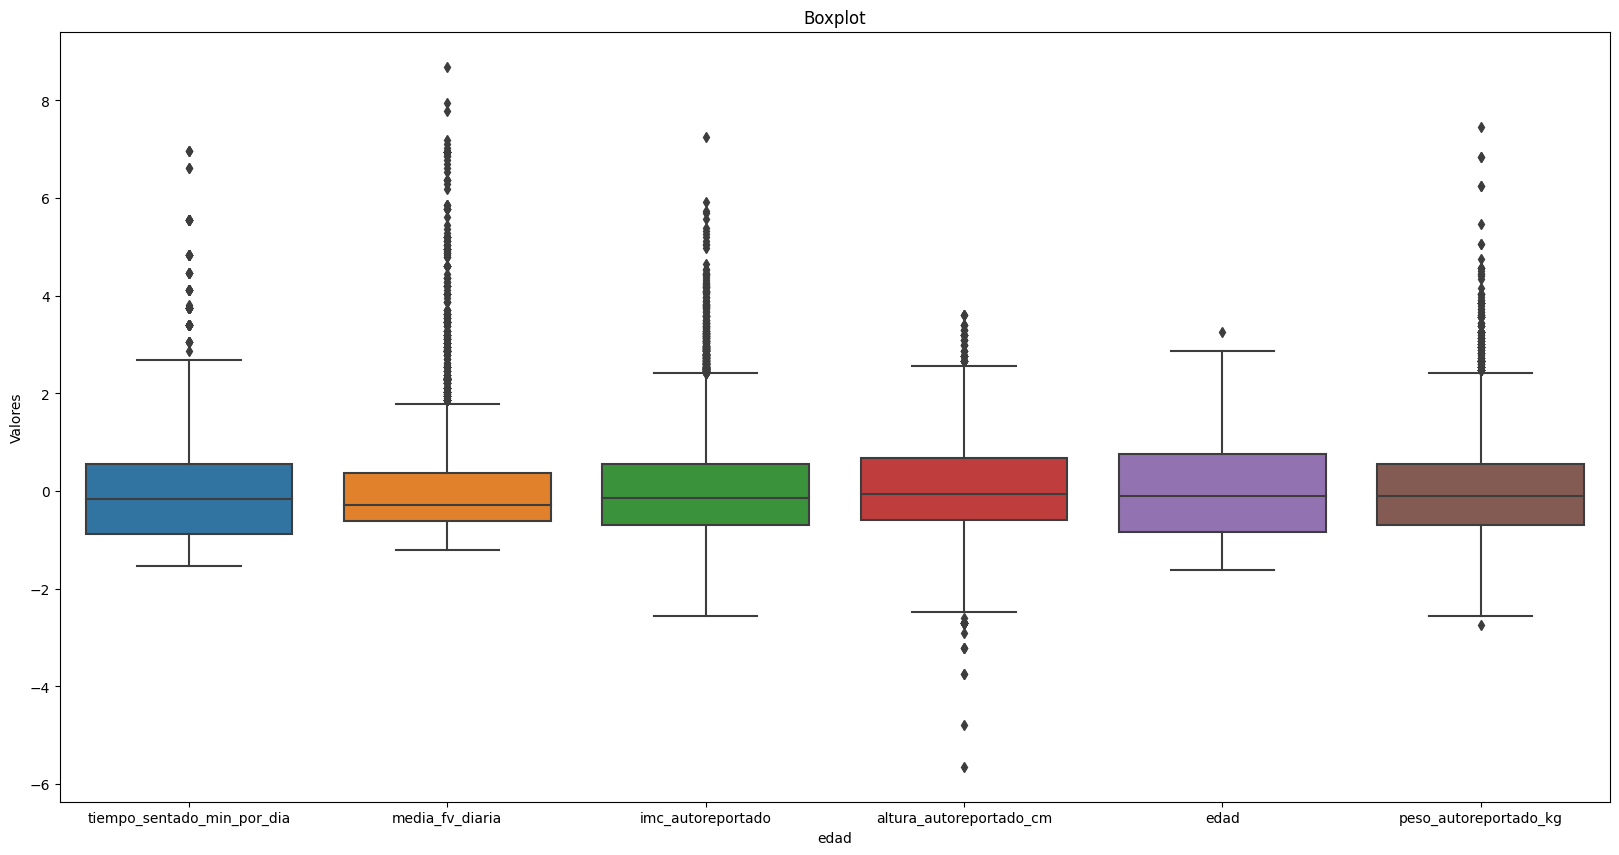

In [19]:
# analisis de los valores para deteccion de outliers en las columnas numericas a utlizar
plt.figure(figsize=(20, 10))
sns.boxplot(data=friesgo_num)
plt.title('Boxplot')
plt.xlabel('edad')
plt.ylabel('Valores')
plt.show()

In [20]:
# Calculamos la cantidad y porcentaje de ouliers
columnas_c_outliers = friesgo_num.columns
indices_outliers = identificar_outliers(features_stn,columnas_c_outliers)

In [21]:
print(f'El porcentaje de outliers es de {(len(indices_outliers)/len(features_stn))*100} %')
print(f'El total numerico de outliers es de : {len(indices_outliers)}')

El porcentaje de outliers es de 8.714781937475879 %
El total numerico de outliers es de : 1129


El porcentaje de outliers es relativamente bajo para cada columna y en total de 1129 registros como maximo con estos, por lo que seran eliminados a continuacion. Se eliminaran el mayor porcentaje posible, aunque el dataframe de salida de este preprocesado sera utilizado para realizar un permutations importance con un modelo de random forest, al cual no afectan  en sobremedida por los outliers, como si es el caso con los algoritmos de clustering, por lo que si las columnas resultantes de permutations importance tienen outliers seran eliminados al 100%.

In [22]:
# eliminar los outliers
col_obj = col_obj.drop(index=indices_outliers)
features_stn = features_stn.drop(indices_outliers,axis=0)

In [23]:
features_stn.shape

(11826, 40)

In [24]:
# verificar que los indices coincidan
iguales = col_obj.index == features_stn.index
np.unique(iguales)

array([ True])

Los registros iniciales fueron 12955 y al eliminar los outliers 11826, una diferencia de 1129 igual a la cantidad de outliers, por lo que se eliminaron el 100% en teoria, ahora observaremos los graficos.

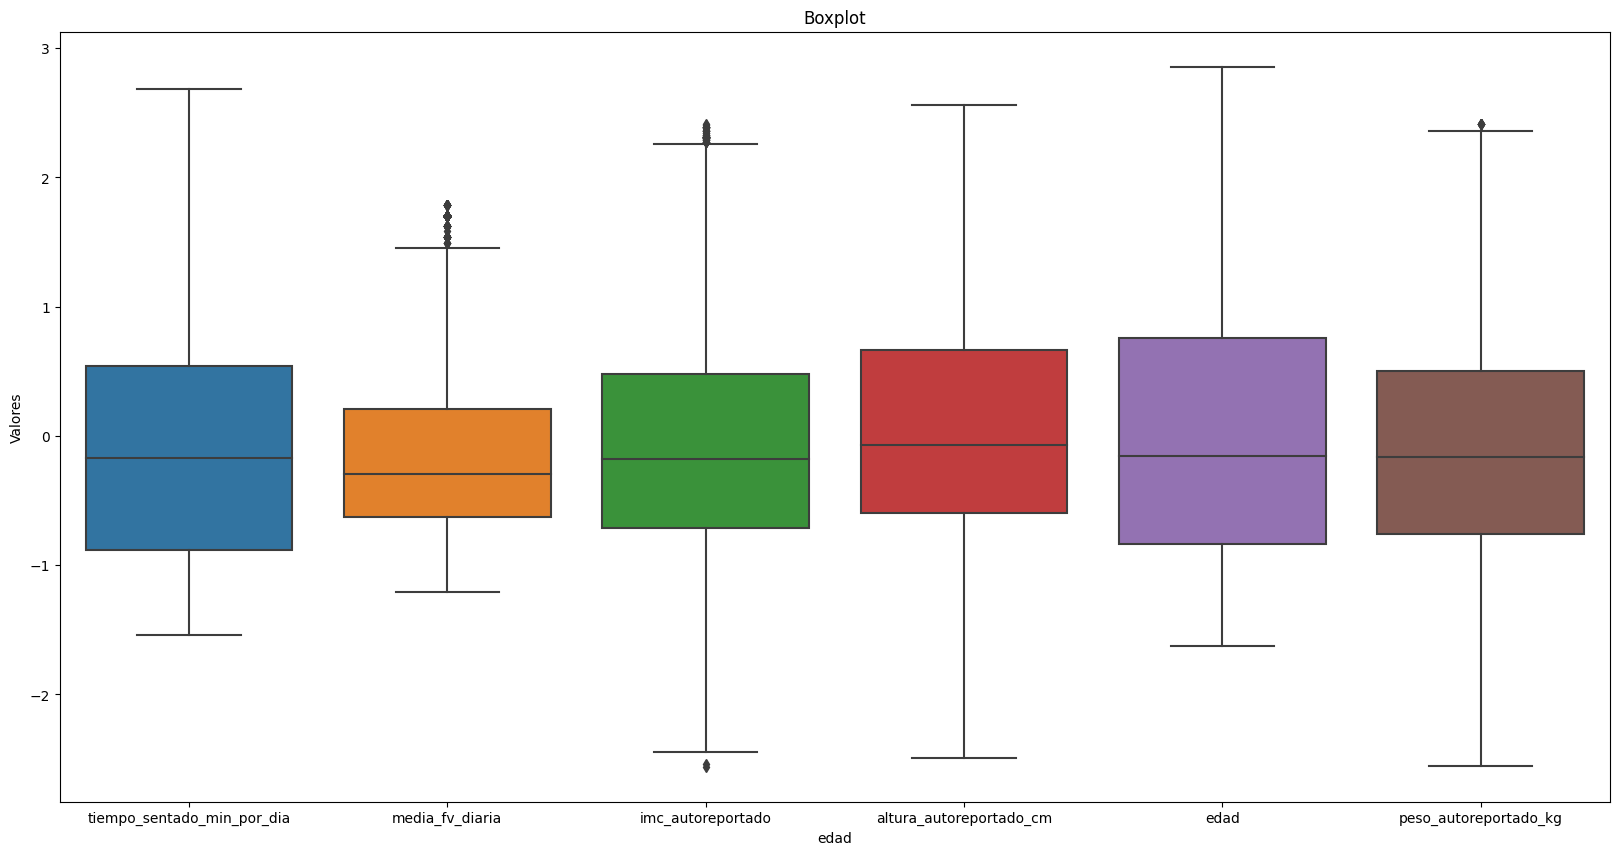

In [25]:
# Graficar
friesgo_num2 = features_stn.filter(items=variables_num)
# analisis de los valores para deteccion de outliers en las columnas numericas a utlizar
plt.figure(figsize=(20, 10))
sns.boxplot(data=friesgo_num2)
plt.title('Boxplot')
plt.xlabel('edad')
plt.ylabel('Valores')
plt.show()

In [26]:
# Calcular el porcentaje y numero de ouliers 
print(calcular_porcentaje_outliers(friesgo_num2.imc_autoreportado))
print(calcular_porcentaje_outliers(friesgo_num2.media_fv_diaria))
print(calcular_porcentaje_outliers(friesgo_num2.peso_autoreportado_kg))
print(calcular_porcentaje_outliers(friesgo_num2.tiempo_sentado_min_por_dia))
print(calcular_porcentaje_outliers(friesgo_num2.edad))
print(calcular_porcentaje_outliers(friesgo_num2.altura_autoreportado_cm))

(0.43125317097919835, 51)
(2.545239303230171, 301)
(0.06764755623203111, 8)
(0.0, 0)
(0.0, 0)
(0.0, 0)


Se eliminaron la mayoria de los outliers quedando solo alrededor de 400 (esto es un problema con la funcion de medicion de porcentaje / de identificacion de outliers que no pudimos solucionar a tiempo)

## Reducción de dimensionalidad

### Paso 1 : Permutation Importance

Se aplica un algoritmo de clasificación Random Forest para evaluar la importancia de las características del dataset. Esto nos permite identificar las columnas más relevantes, lo que facilita la reducción de dimensionalidad al eliminar aquellas con menor relevancia.

In [27]:
# Separar los conjuntos para entrenamiento y testeo
y = col_obj
X = features_stn
X_train_pi, X_test_pi, y_train_pi, y_test_pi = train_test_split(X, y, test_size=0.3, random_state=42)

In [28]:
# Entrenar el modelo para tener los parametros de accuracy de base
modelo = RandomForestClassifier(random_state=42,criterion= 'gini', n_estimators=200, max_depth=8)

# Ajustar el modelo
modelo.fit(X_train_pi, y_train_pi)

RandomForestClassifier(max_depth=8, n_estimators=200, random_state=42)

In [29]:
# Calcular el acurracy base
y_pred_pi = modelo.predict(X_test_pi)
acc = accuracy_score(y_test_pi, y_pred_pi)
acc

0.7302705749718151

In [30]:
# Calcular Permutation Importance
perm = permutation_importance(modelo, X_test_pi, y_test_pi,random_state=1)

In [31]:
# Ordenar las características por importancia promedio
indices = np.argsort(perm.importances_mean)  # Orden ascendente
features = X_test_pi.columns[indices]
importances = perm.importances_mean[indices]
importances_std = perm.importances_std[indices]

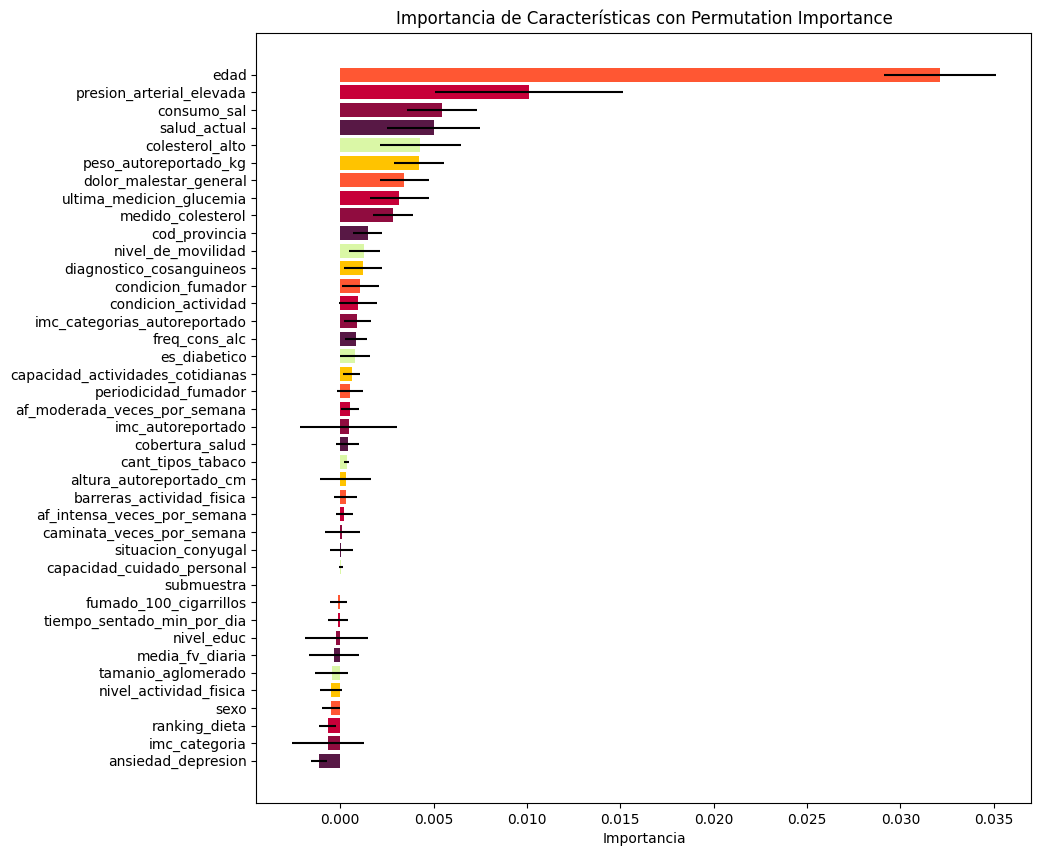

In [32]:
# Crear el gráfico de barras
plt.figure(figsize=(10, 10))
plt.barh(features, importances, xerr=importances_std, align='center',color=['#581845','#900C3F','#C70039','#FF5733','#FFC300','#DAF7A6'])
plt.xlabel('Importancia')
plt.title('Importancia de Características con Permutation Importance')
plt.show()

Se seleccionarán las 10 características principales, que son aquellas que más contribuyen a la precisión del modelo. 

In [33]:
# Se seleccionaran a partir del dataframe sin procesar para rescatar los valores eliminados por ser nulos en columnas que ya no estan presentes
friesgo_reducida = friesgo_raw.filter(items=['edad','presion_arterial_elevada','consumo_sal','salud_actual','colesterol_alto','peso_autoreportado_kg','dolor_malestar_general','ultima_medicion_glucemia','medido_colesterol','cod_provincia'
])

In [34]:
calcular_nulos_y_porcentaje(friesgo_reducida)

,Nulos,Porcentaje
edad,0,0.0%
presion_arterial_elevada,12997,44.47%
consumo_sal,0,0.0%
salud_actual,0,0.0%
colesterol_alto,0,0.0%
peso_autoreportado_kg,1011,3.46%
dolor_malestar_general,0,0.0%
ultima_medicion_glucemia,0,0.0%
medido_colesterol,0,0.0%
cod_provincia,0,0.0%


Este nuevo DataFrame servirá de entrada para los siguientes algoritmos no supervisados.

### Preprocesado de df reducido

In [35]:
auxm = friesgo_reducida.copy().dropna()
auxm.shape

(15599, 10)

In [36]:
auxm.head()

,edad,presion_arterial_elevada,consumo_sal,salud_actual,colesterol_alto,peso_autoreportado_kg,dolor_malestar_general,ultima_medicion_glucemia,medido_colesterol,cod_provincia
0,32,1.0,5,3,2,104.0,1,2,1,2
7,42,2.0,3,2,1,57.0,1,1,1,2
8,32,1.0,4,1,2,82.0,1,3,1,2
11,76,1.0,5,3,2,92.0,1,1,1,2
13,63,1.0,4,4,2,84.0,2,1,1,2


In [37]:
print(calcular_porcentaje_outliers(auxm.edad))
print(calcular_porcentaje_outliers(auxm.peso_autoreportado_kg))

(0.006410667350471184, 1)
(1.6988268478748638, 265)


In [38]:
auxm.dtypes

edad                          int64
presion_arterial_elevada    float64
consumo_sal                   int64
salud_actual                  int64
colesterol_alto               int64
peso_autoreportado_kg       float64
dolor_malestar_general        int64
ultima_medicion_glucemia      int64
medido_colesterol             int64
cod_provincia                 int64
dtype: object

In [39]:
auxm.columns

Index(['edad', 'presion_arterial_elevada', 'consumo_sal', 'salud_actual',
       'colesterol_alto', 'peso_autoreportado_kg', 'dolor_malestar_general',
       'ultima_medicion_glucemia', 'medido_colesterol', 'cod_provincia'],
      dtype='object')

In [40]:
# Codificación de columnas categoricas
le = LabelEncoder()
categoricas = ['presion_arterial_elevada', 'consumo_sal', 'salud_actual','colesterol_alto', 'dolor_malestar_general','ultima_medicion_glucemia', 'medido_colesterol', 'cod_provincia']
for columnas in categoricas:
    auxm[columnas] = le.fit_transform(auxm[columnas])

In [41]:
auxm.head()

,edad,presion_arterial_elevada,consumo_sal,salud_actual,colesterol_alto,peso_autoreportado_kg,dolor_malestar_general,ultima_medicion_glucemia,medido_colesterol,cod_provincia
0,32,0,3,2,1,104.0,0,1,0,0
7,42,1,1,1,0,57.0,0,0,0,0
8,32,0,2,0,1,82.0,0,2,0,0
11,76,0,3,2,1,92.0,0,0,0,0
13,63,0,2,3,1,84.0,1,0,0,0


In [42]:
# Estandarizar columnas numericas
numericas = ['edad','peso_autoreportado_kg']
auxm['edad'] = scaler.fit_transform(auxm[['edad']]).flatten()
auxm['peso_autoreportado_kg'] = scaler.fit_transform(auxm[['peso_autoreportado_kg']]).flatten()

In [43]:
auxm.head()

,edad,presion_arterial_elevada,consumo_sal,salud_actual,colesterol_alto,peso_autoreportado_kg,dolor_malestar_general,ultima_medicion_glucemia,medido_colesterol,cod_provincia
0,-0.790248,0,3,2,1,1.712710,0,1,0,0
7,-0.230687,1,1,1,0,-1.103666,0,0,0,0
8,-0.790248,0,2,0,1,0.394406,0,2,0,0
11,1.671823,0,3,2,1,0.993636,0,0,0,0
13,0.944392,0,2,3,1,0.514252,1,0,0,0


## Paso 2: Modelos de reducción de dimensionalidad

### PCA

#### Estandarizar datos

PCA es sensible a la escala de las columnas. La estandarización asegura que cada característica contribuya igualmente al análisis.

In [44]:
# Estandarización de los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(auxm)
scaled_data

array([[-0.79024847, -1.22795676,  1.39266459, ..., -0.08137297,
        -0.66339768, -1.3281036 ],
       [-0.23068688,  0.81436092, -0.93988224, ..., -0.84191036,
        -0.66339768, -1.3281036 ],
       [-0.79024847, -1.22795676,  0.22639117, ...,  0.67916443,
        -0.66339768, -1.3281036 ],
       ...,
       [ 0.8884363 ,  0.81436092,  0.22639117, ..., -0.08137297,
        -0.66339768,  1.89427434],
       [ 1.55991021, -1.22795676,  0.22639117, ..., -0.84191036,
        -0.66339768,  1.89427434],
       [-0.3425992 , -1.22795676,  1.39266459, ..., -0.84191036,
        -0.66339768,  1.89427434]])

#### Evaluar el número óptimo de componentes para PCA

Para conservar el 80% de información al aplicar PCA, hay que seleccionar el número de componentes principales que en conjunto expliquen al menos el 95% de la varianza total.

In [45]:
pca = PCA(n_components = 0.80)
pca_data = pca.fit_transform(scaled_data)
n_components = pca.n_components_

# Ver el número de componentes seleccionados automáticamente
print(f"Número de componentes seleccionados: {n_components}")

Número de componentes seleccionados: 7


#### Aplicar PCA 

Se aplica PCA con el número de componentes principales calculado con anterioridad.

In [46]:
# Aplicar PCA con el número óptimo de componentes
pca_opt = PCA(n_components = n_components)
pca_opt_data = pca_opt.fit_transform(scaled_data)

# Convertir a DataFrame para facilitar el manejo
pca_df = pd.DataFrame(data = pca_opt_data, columns = [f'PC{i+1}' for i in range(n_components)])
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,-0.629346,0.185646,2.288828,-0.396797,-0.451186,1.071706,1.103503
1,-0.178164,-2.344534,-0.824865,-1.115680,0.981511,0.797168,-0.809020
2,0.745412,-0.926844,2.125307,-0.883871,-0.097137,0.102606,-0.089116
3,-1.939684,-0.239334,1.963438,-0.890369,-1.172631,-0.068190,0.465731
4,-2.097166,0.971080,0.342604,-1.565634,-0.278024,-0.496128,0.785299
...,...,...,...,...,...,...,...
15594,-1.392193,-0.135373,-1.038395,1.444509,-0.572221,-1.381308,-0.073645
15595,0.777949,-0.689554,0.153848,2.245567,0.412521,-0.240742,0.795670
15596,-1.212397,-0.368224,-0.397063,2.199480,0.755793,0.816464,-0.699200
15597,-2.161850,-0.431731,0.122281,1.698657,0.180230,-0.619133,-1.949142


#### Visualizar la varianza explicada 

Permite ver cómo cada componente principal contribuye a la varianza total y cómo se acumula la varianza explicada.

In [47]:
# Obtener la varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_

# Imprimir la varianza explicada por cada componente principal
print('Varianza explicada')
for i in range(n_components):
    print('PC{}: {}'.format(i+1, pca.explained_variance_ratio_[i]))

Varianza explicada
PC1: 0.24176260279045503
PC2: 0.13237475735731177
PC3: 0.11393683287049823
PC4: 0.10216067470183098
PC5: 0.09632744060140566
PC6: 0.07877567987501886
PC7: 0.07476928609307709


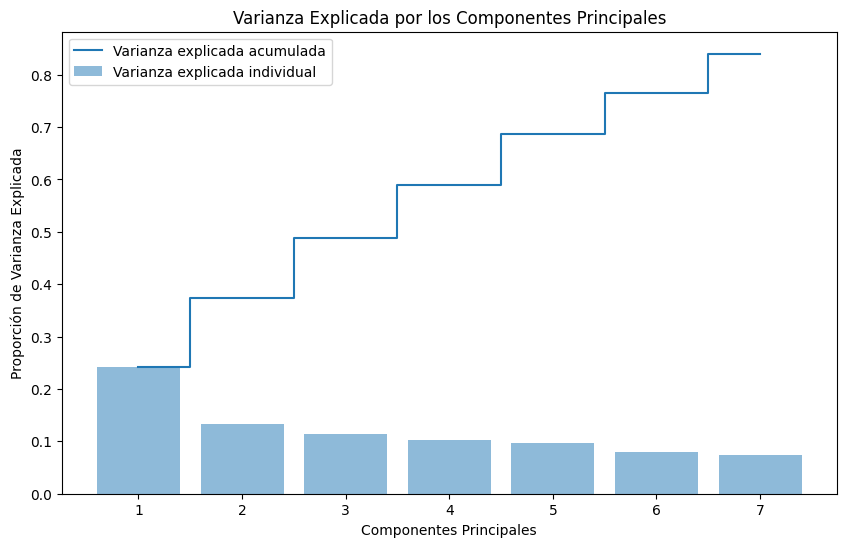

In [48]:
# Visualización de la varianza explicada por cada componente
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Varianza explicada individual')
plt.step(range(1, len(np.cumsum(explained_variance)) + 1), np.cumsum(explained_variance), where='mid', label='Varianza explicada acumulada')
plt.xlabel('Componentes Principales')
plt.ylabel('Proporción de Varianza Explicada')
plt.title('Varianza Explicada por los Componentes Principales')
plt.legend(loc='best')
plt.show()

In [49]:
def plot_3d_scatter(ax, data, view_angle=(90, 30)):
    """
    Función para crear un scatterplot 3D dado un subplot y datos.
    
    Parameters:
    - ax: El objeto Axes3D donde se dibujará el scatterplot.
    - data: DataFrame que contiene las columnas 'PC1', 'PC2', 'PC3', y 'PC4'.
    - view_angle: Tuple que contiene los ángulos de elevación y azimut (elev, azim).
    """
    '''
    group1 = data[data['PC4'] == 0]
    group2 = data[data['PC4'] == 1]
    group3 = data[data['PC4'] == 2]
    
    # Graficar los tres grupos con diferentes colores y marcadores
   
    ax.scatter(group1['PC1'], group1['PC2'], group1['PC3'], color='r', label='Cluster 0', marker='o', alpha=0.7)
    ax.scatter(group2['PC1'], group2['PC2'], group2['PC3'], color='g', label='Cluster 1', marker='^', alpha=0.7)
    ax.scatter(group3['PC1'], group3['PC2'], group3['PC3'], color='b', label='Cluster 2', marker='s', alpha=0.7)
'''
    ax.scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['PC4'],
                     cmap='tab20', marker='o', alpha=0.7)
    
    # Etiquetas de los ejes
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    
    # Configurar la vista
    ax.view_init(elev=view_angle[0], azim=view_angle[1])
    
    # Título del gráfico con el ángulo actual
    ax.set_title(f'Vista: Elev={view_angle[0]}, Azim={view_angle[1]}')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


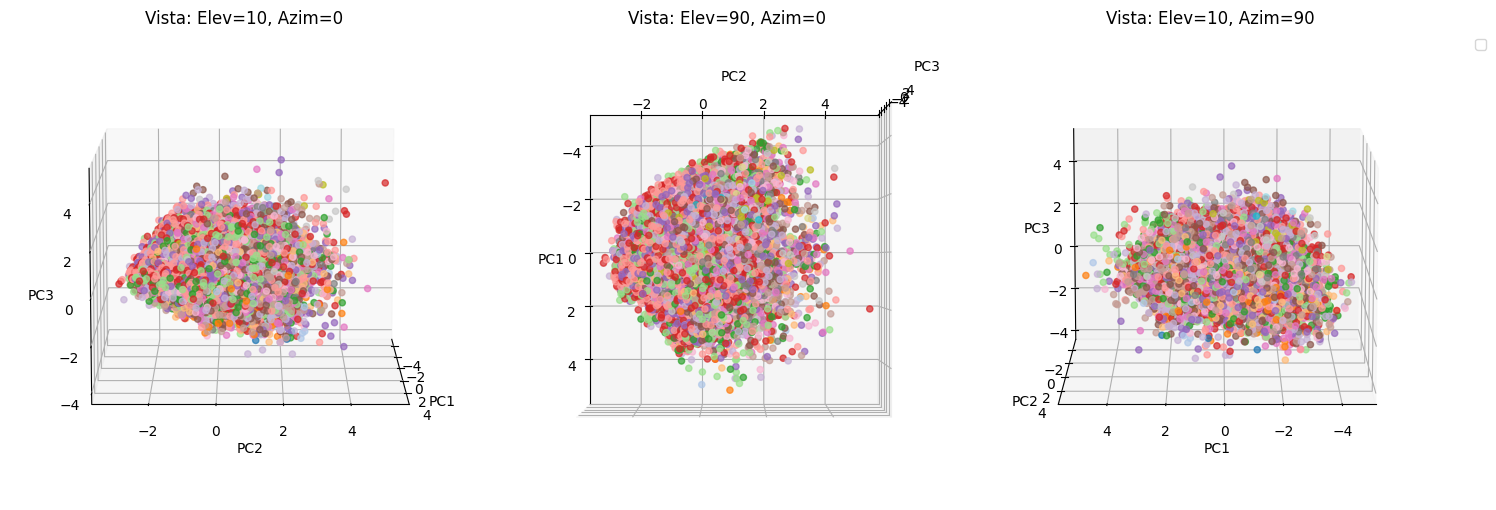

In [50]:
# Configurar la figura con tres subplots
fig = plt.figure(figsize=(15, 5))

# Definir los ángulos para cada vista
angles = [(10, 0), (90, 0), (10, 90)]

# Crear subplots con diferentes vistas usando la función
for i, angle in enumerate(angles):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    plot_3d_scatter(ax, pca_df, view_angle=angle)

# Añadir una leyenda fuera de los subplots
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

# Mostrar el gráfico
plt.tight_layout()
plt.show()


## FAMD

In [51]:
subset_famd = friesgo_reducida.copy().dropna()

In [52]:
subset_famd.dtypes

edad                          int64
presion_arterial_elevada    float64
consumo_sal                   int64
salud_actual                  int64
colesterol_alto               int64
peso_autoreportado_kg       float64
dolor_malestar_general        int64
ultima_medicion_glucemia      int64
medido_colesterol             int64
cod_provincia                 int64
dtype: object

In [53]:

le = LabelEncoder()
categoricas = ['presion_arterial_elevada', 'consumo_sal', 'salud_actual','colesterol_alto', 'dolor_malestar_general','ultima_medicion_glucemia', 'medido_colesterol', 'cod_provincia']
for columnas in categoricas:
    auxm[columnas] = le.fit_transform(auxm[columnas])

In [54]:
subset_famd[categoricas] = subset_famd[categoricas].astype('category')


In [55]:
subset_famd.dtypes

edad                           int64
presion_arterial_elevada    category
consumo_sal                 category
salud_actual                category
colesterol_alto             category
peso_autoreportado_kg        float64
dolor_malestar_general      category
ultima_medicion_glucemia    category
medido_colesterol           category
cod_provincia               category
dtype: object

In [56]:
subset_famd['peso_autoreportado_kg'] = subset_famd['peso_autoreportado_kg'].astype('float')
subset_famd['edad']=subset_famd['edad'].astype('float')


In [57]:
subset_famd.head()

,edad,presion_arterial_elevada,consumo_sal,salud_actual,colesterol_alto,peso_autoreportado_kg,dolor_malestar_general,ultima_medicion_glucemia,medido_colesterol,cod_provincia
0,32.0,1.0,5,3,2,104.0,1,2,1,2
7,42.0,2.0,3,2,1,57.0,1,1,1,2
8,32.0,1.0,4,1,2,82.0,1,3,1,2
11,76.0,1.0,5,3,2,92.0,1,1,1,2
13,63.0,1.0,4,4,2,84.0,2,1,1,2


In [58]:
subset_famd['edad'] = scaler.fit_transform(subset_famd[['edad']]).flatten()
subset_famd['peso_autoreportado_kg'] = scaler.fit_transform(subset_famd[['peso_autoreportado_kg']]).flatten()

In [59]:
subset_famd.dtypes

edad                         float64
presion_arterial_elevada    category
consumo_sal                 category
salud_actual                category
colesterol_alto             category
peso_autoreportado_kg        float64
dolor_malestar_general      category
ultima_medicion_glucemia    category
medido_colesterol           category
cod_provincia               category
dtype: object

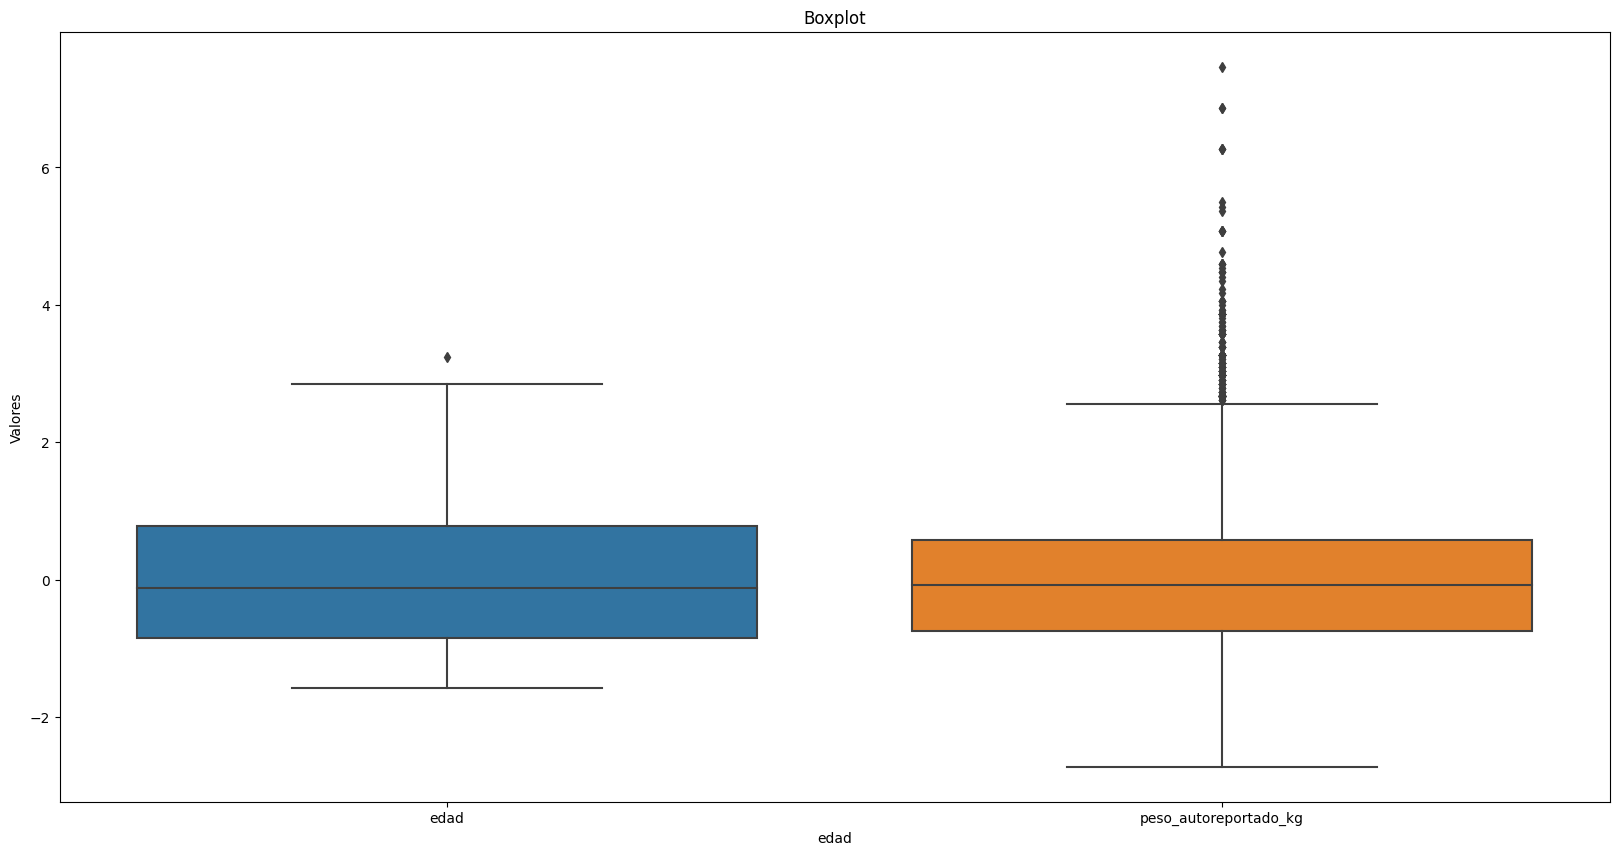

In [60]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=subset_famd[numericas])
plt.title('Boxplot')
plt.xlabel('edad')
plt.ylabel('Valores')
plt.show()

In [61]:
subset_famd = subset_famd[subset_famd['peso_autoreportado_kg'] <= 120]


In [62]:
calcular_nulos_y_porcentaje(subset_famd)

,Nulos,Porcentaje
edad,0,0.0%
presion_arterial_elevada,0,0.0%
consumo_sal,0,0.0%
salud_actual,0,0.0%
colesterol_alto,0,0.0%
peso_autoreportado_kg,0,0.0%
dolor_malestar_general,0,0.0%
ultima_medicion_glucemia,0,0.0%
medido_colesterol,0,0.0%
cod_provincia,0,0.0%


In [63]:
famd = prince.FAMD(n_components=7, engine='sklearn')
famd.fit(subset_famd)

/opt/anaconda3/lib/python3.11/site-packages/prince/pca.py:175: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[-0.40605709482056684, -0.7955256632180482, -0.3710810352040657, -0.5225843751300573, -0.40763279765520966, -0.38063247643973935, -0.3779281261939868, -0.4687831873842664, -0.3809691704254658, -0.40161223902896065, -0.29829526114998883, -0.31785549773981553, -0.36127716127039267, -0.42668835553994394, -0.2970030012348082, -0.4503704197312566, -0.41511292244480347, -0.3113346918336026, -0.34157597365531367, -0.2842083894186393, -0.5166625479688073, -0.30760599814203016, -0.37758872053396825, -0.2166242945873086, -0.9492541297156571, -1.7434683911385995, -0.2433815241926834, -0.6326784881465631, -0.8562265577520266, -1.4523656512734795, -0.8701885010948239, -1.709605644125809, -0.9699636799154652, -0.36934942969771434, -1.6535651902247366, -1.102363870487108, -0.2247577778892489, -1.2629228150592697, -1.55081461277703, -0.6160450528556285, -0.98204928

FAMD(n_components=7)

In [64]:
eigenvalues = famd.eigenvalues_
print(eigenvalues)


[8.6626573  5.63189282 5.51618293 4.65310673 4.40212929 4.26723788
 4.18099608]


In [65]:
total_variance = eigenvalues.sum()
total_variance

37.31420303022767

In [66]:
explained_variance_ratio = eigenvalues / total_variance
print(explained_variance_ratio)

[0.23215442 0.15093161 0.14783065 0.12470069 0.11797463 0.11435961
 0.11204838]


In [67]:
total_variance_explained = explained_variance_ratio.sum()
print(total_variance_explained)

1.0


In [68]:
famd2 = prince.FAMD(n_components=3, engine='sklearn')
famd2.fit(subset_famd)

/opt/anaconda3/lib/python3.11/site-packages/prince/pca.py:175: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[-0.40605709482056684, -0.7955256632180482, -0.3710810352040657, -0.5225843751300573, -0.40763279765520966, -0.38063247643973935, -0.3779281261939868, -0.4687831873842664, -0.3809691704254658, -0.40161223902896065, -0.29829526114998883, -0.31785549773981553, -0.36127716127039267, -0.42668835553994394, -0.2970030012348082, -0.4503704197312566, -0.41511292244480347, -0.3113346918336026, -0.34157597365531367, -0.2842083894186393, -0.5166625479688073, -0.30760599814203016, -0.37758872053396825, -0.2166242945873086, -0.9492541297156571, -1.7434683911385995, -0.2433815241926834, -0.6326784881465631, -0.8562265577520266, -1.4523656512734795, -0.8701885010948239, -1.709605644125809, -0.9699636799154652, -0.36934942969771434, -1.6535651902247366, -1.102363870487108, -0.2247577778892489, -1.2629228150592697, -1.55081461277703, -0.6160450528556285, -0.98204928

FAMD(n_components=3)

In [69]:
eigenvalues2 = famd2.eigenvalues_
total_variance2 = eigenvalues2.sum()
explained_variance_ratio2 = eigenvalues2 / total_variance2
total_variance_explained2 = explained_variance_ratio2.sum()
print(explained_variance_ratio2)
print(total_variance_explained2)

[0.44418267 0.28420736 0.27160998]
1.0


In [70]:
row_coord_FAMD = famd2.row_coordinates(subset_famd)

/opt/anaconda3/lib/python3.11/site-packages/prince/pca.py:175: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[-0.40605709482056684, -0.7955256632180482, -0.3710810352040657, -0.5225843751300573, -0.40763279765520966, -0.38063247643973935, -0.3779281261939868, -0.4687831873842664, -0.3809691704254658, -0.40161223902896065, -0.29829526114998883, -0.31785549773981553, -0.36127716127039267, -0.42668835553994394, -0.2970030012348082, -0.4503704197312566, -0.41511292244480347, -0.3113346918336026, -0.34157597365531367, -0.2842083894186393, -0.5166625479688073, -0.30760599814203016, -0.37758872053396825, -0.2166242945873086, -0.9492541297156571, -1.7434683911385995, -0.2433815241926834, -0.6326784881465631, -0.8562265577520266, -1.4523656512734795, -0.8701885010948239, -1.709605644125809, -0.9699636799154652, -0.36934942969771434, -1.6535651902247366, -1.102363870487108, -0.2247577778892489, -1.2629228150592697, -1.55081461277703, -0.6160450528556285, -0.98204928

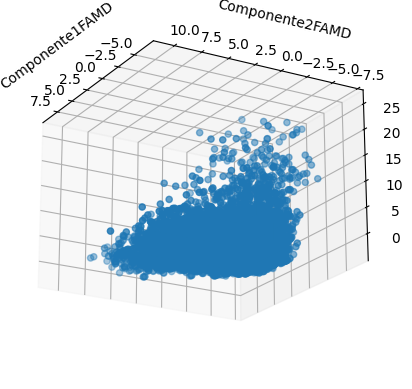

In [71]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(row_coord_FAMD.iloc[:, 0], row_coord_FAMD.iloc[:, 1], row_coord_FAMD.iloc[:, 2])

ax.set_xlabel('Componente1FAMD')
ax.set_ylabel('Componente2FAMD')
ax.set_zlabel('Componente3FAMD')
ax.view_init(elev=-20, azim=150)

plt.show()

### ACA ESTAN LAS COORDENADAS DE LAS 15599 FILAS EN LAS COMPONENTES QUE DIO EL FAMD --- LOS INDEX ESTÁN SALTEADO PORQUE SE ELIMINARON FILAS AL ELIMINAR NULOS Y OUTLIERS

In [72]:

# Create a new DataFrame with components as columns and row coordinates as rows
component_df = pd.DataFrame(row_coord_FAMD.values, columns=[f"Component {i+1}" for i in range(row_coord_FAMD.shape[1])], index=subset_famd.index)

print(component_df)

       Component 1  Component 2  Component 3
0         1.813915    -3.616015     0.367369
7         1.961163    -5.554376    -0.615400
8        -0.185969    -4.337532    -1.234610
11        2.901561    -3.192952     0.292020
13        4.099068     0.283085    -0.700913
...            ...          ...          ...
29216     1.979555    -1.079246     1.590445
29217    -0.465376    -4.044763     1.256121
29220     2.069816    -3.737993     1.252683
29221     3.744414    -2.932400     1.272377
29223     3.320402    -0.486273     3.338677

[15599 rows x 3 columns]


## Análisis de modelos

### Modelo 1: K-Means

Para la aplicacion de este modelo se seguiran los siguientes pasos:

+ 1 : Calculo de la cantidad optima de clusters mediante la tecnica visual del "codo"
+ 2 : Calculo de la cantidad optima de cluster mediante metodo Silhouette Score
+ 3 : Aplicacion del modelo 
+ 4 : Graficado de clusters 2d,3d y centroides
+ 5 : Identificacion de clusters



#### Paso 1

In [73]:
# Test codo pca_df reducida
inertias = []
k_range = range(1,15) 

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=20, max_iter=500, random_state=42)
    kmeans.fit(auxm) # aplicar kmeans a mi dataframe
    inertias.append(kmeans.inertia_)

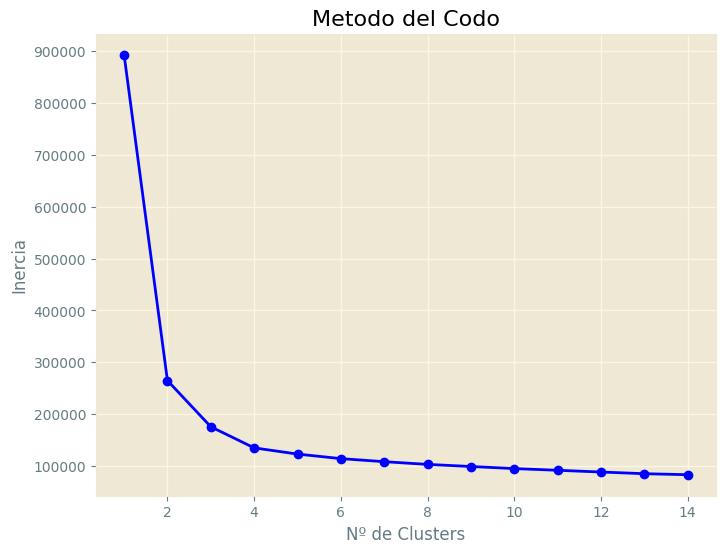

In [74]:
# Graficar el metodo del codo
plt.figure(figsize=(8, 6))
plt.style.use('Solarize_Light2')
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Nº de Clusters')
plt.ylabel('Inercia')
plt.title('Metodo del Codo')
plt.show()

Del grafico puede observarse que la inercia comienza a disminuir de manera menos pronunciada alrededor de los 2 a 4 clusters, aunque el codo es pronunciado, se utilizaran esos valores de cluster (2,3,4) y se evaluaran con Silhouette Score para determinar el optimo.

#### Paso 2

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Para n_clusters = 2, el Silhouette Score promedio es: 0.56


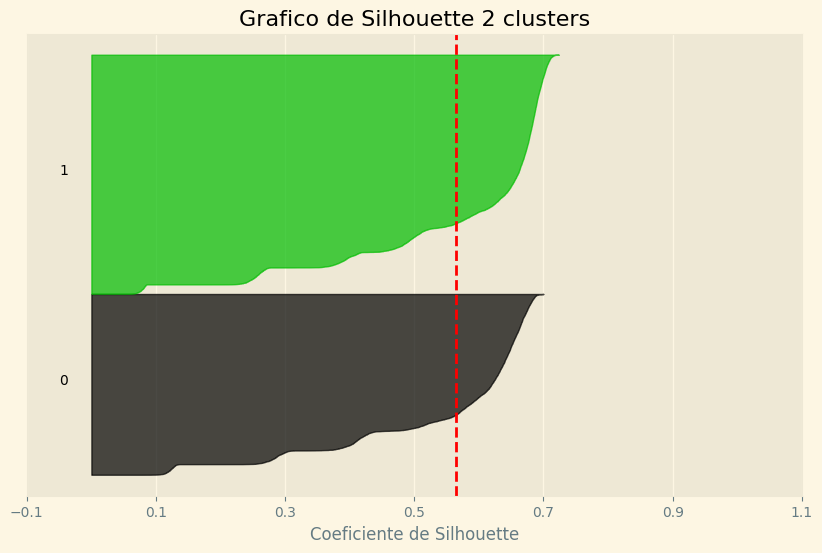

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Para n_clusters = 3, el Silhouette Score promedio es: 0.43


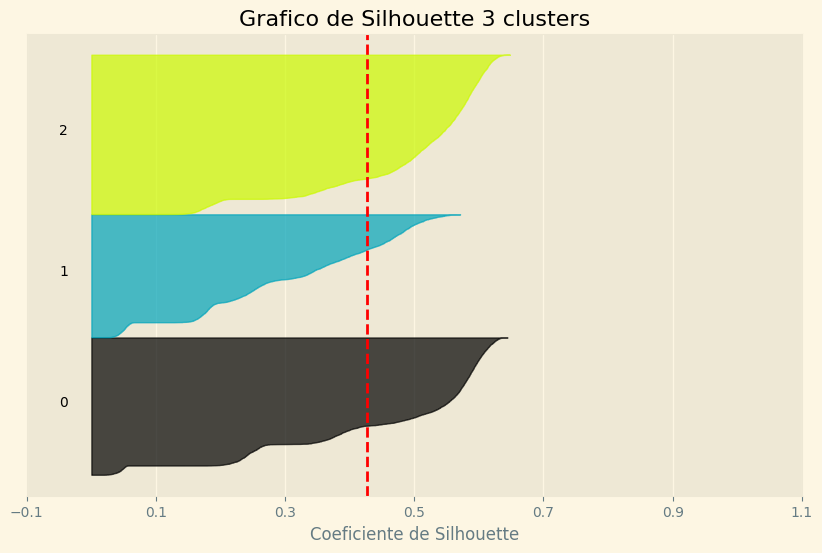

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Para n_clusters = 4, el Silhouette Score promedio es: 0.36


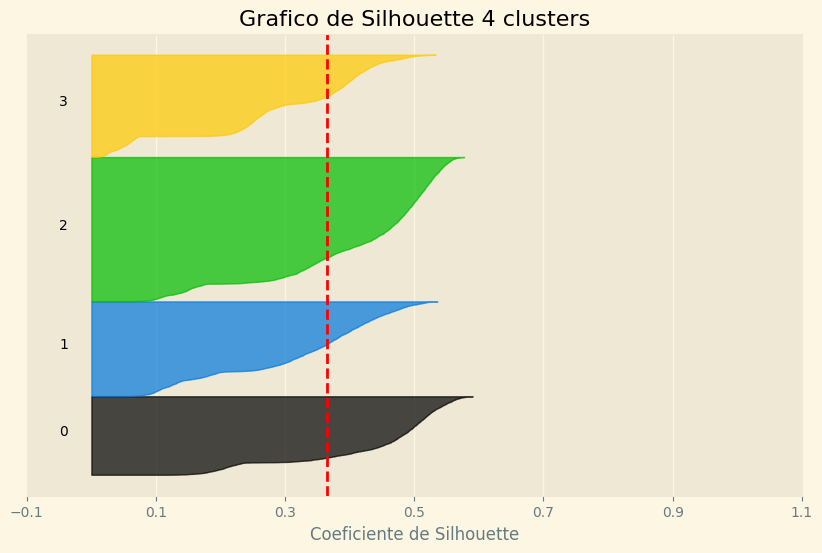

In [75]:
range_n_clusters = [2,3,4]  # Numeros de clusters a probar

for n_clusters in range_n_clusters:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Aplicar K-means
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    cluster_labels = kmeans.fit_predict(auxm)
    
    # Calcular el Silhouette Score promedio
    silhouette_avg = silhouette_score(auxm, cluster_labels)
    print(f"Para n_clusters = {n_clusters}, el Silhouette Score promedio es: {silhouette_avg:.2f}")
    
    # Calcular los Silhouette Scores para cada punto
    sample_silhouette_values = silhouette_samples(auxm, cluster_labels)
    
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)
        
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        y_lower = y_upper + 10  
    
    ax.set_title(f"Grafico de Silhouette {n_clusters} clusters")
    ax.set_xlabel("Coeficiente de Silhouette")
    ax.set_ylabel("")
    
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])  
    ax.set_xticks(np.arange(-0.1, 1.1, 0.2))
    
    plt.show()

Los graficos de Silhouette Score muestran una cohesion maxima del 70% aprox y 56% promedio para un numero de clusters igual a 2, al aumentar los n clusters estos parametros disminuyen; por lo que se concluye que los grupos se diferencian mejor cuando se agrupan en 2, por lo que se usara este parametro.

#### Paso 3

In [76]:
# Aplicar modelo
cluster =  KMeans(n_clusters=2, init='k-means++', random_state=42)
cluster.fit(auxm)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=2, random_state=42)

In [77]:
# Agregar las etiquetas generadas por el algoritmo al dataframe
salida_kmeans = auxm.copy()
salida_kmeans['cluster_label'] = cluster.labels_
salida_kmeans.head(5)

,edad,presion_arterial_elevada,consumo_sal,salud_actual,colesterol_alto,peso_autoreportado_kg,dolor_malestar_general,ultima_medicion_glucemia,medido_colesterol,cod_provincia,cluster_label
0,-0.790248,0,3,2,1,1.712710,0,1,0,0,1
7,-0.230687,1,1,1,0,-1.103666,0,0,0,0,1
8,-0.790248,0,2,0,1,0.394406,0,2,0,0,1
11,1.671823,0,3,2,1,0.993636,0,0,0,0,1
13,0.944392,0,2,3,1,0.514252,1,0,0,0,1


#### Paso 4

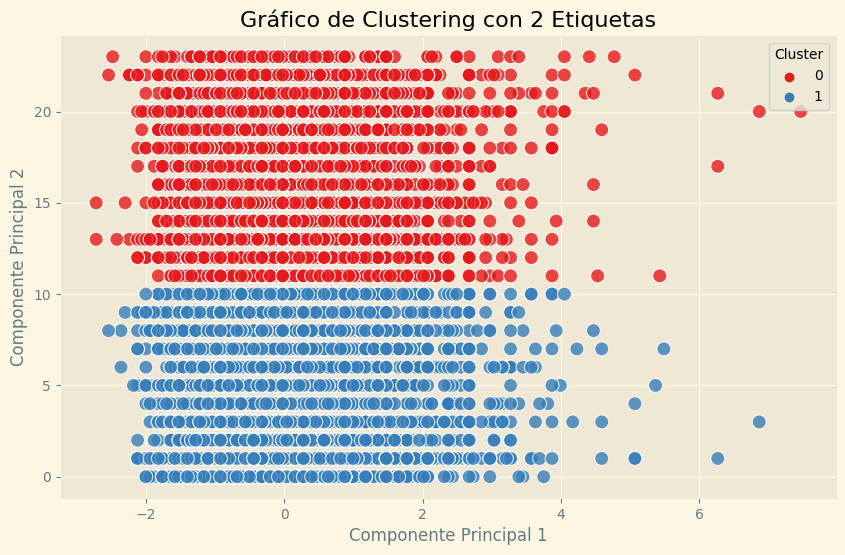

In [78]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=salida_kmeans.peso_autoreportado_kg, y=salida_kmeans.cod_provincia, hue=salida_kmeans.cluster_label, data=salida_kmeans, palette='Set1', s=100, alpha=0.8)
plt.title('Gráfico de Clustering con 2 Etiquetas')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.show()

In [79]:
# centroides
centroids = cluster.cluster_centers_
centroids_df = pd.DataFrame(centroids)
print(centroids_df)

          0         1         2         3         4         5         6  \
0 -0.056546  0.612774  1.825815  1.886110  0.784428  0.025992  0.327974   
1  0.042762  0.592547  1.790813  1.793628  0.793402 -0.019657  0.284846   

          7         8          9  
0  1.132649  0.331696  16.780706  
1  1.087593  0.327066   3.957892  


In [80]:
def plot_3d_scatter(ax, data, view_angle=(90, 30)):
    # Extraer los centroides
   # centroids = centroid_df.iloc[:, :3].values  # Convertir a Numpy array
    centroids = centroids_df.iloc[:, [1, 5, 7]].values
    # Graficar los centroides
    ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], s=100, c='red', marker='X')
    
    # Graficar los puntos de datos
    ax.scatter(
        data['cod_provincia'], 
        data['peso_autoreportado_kg'], 
        data['presion_arterial_elevada'], 
        c=data['cluster_label'], 
        cmap='tab20', 
        marker='o', 
        alpha=0.7
    )
    
    # Etiquetas de los ejes
    ax.set_xlabel('cod_prov')
    ax.set_ylabel('peso_autoreportado')
    ax.set_zlabel('presion_arterial_elevada')
    
    # Configurar la vista
    ax.view_init(elev=view_angle[0], azim=view_angle[1])
    
    # Título del gráfico con el ángulo actual
    ax.set_title(f'Vista: Elev={view_angle[0]}, Azim={view_angle[1]}')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


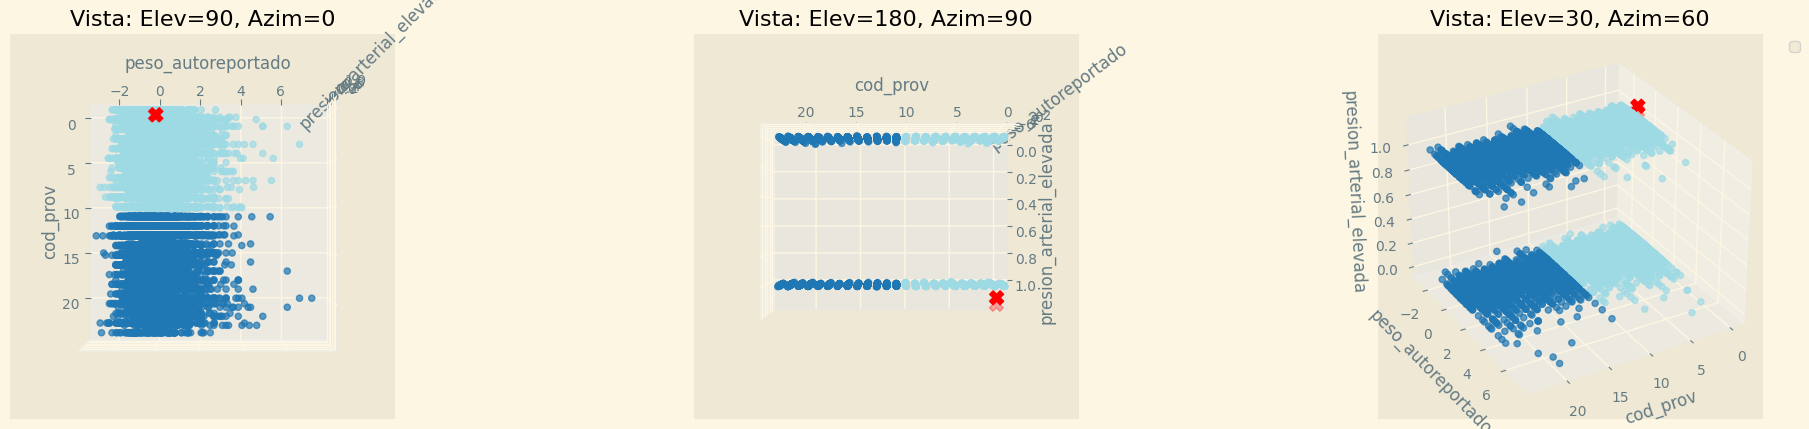

In [81]:
# Ejemplo de uso
fig = plt.figure(figsize=(25, 5))
angles = [(90, 0), (180, 90), (30, 60)]

for i, angle in enumerate(angles):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    plot_3d_scatter(ax, salida_kmeans, view_angle=angle)

# Añadir una leyenda fuera de los subplots
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()

#### Paso 5

In [82]:
# Analisis de importancia de variable/columna
cluster_means = salida_kmeans.groupby('cluster_label').mean()
print(cluster_means)


                   edad  presion_arterial_elevada  consumo_sal  salud_actual  \
cluster_label                                                                  
0             -0.056546                  0.612774     1.825815      1.886110   
1              0.042762                  0.592547     1.790813      1.793628   

               colesterol_alto  peso_autoreportado_kg  dolor_malestar_general  \
cluster_label                                                                   
0                     0.784428               0.025992                0.327974   
1                     0.793402              -0.019657                0.284846   

               ultima_medicion_glucemia  medido_colesterol  cod_provincia  
cluster_label                                                              
0                              1.132649           0.331696      16.780706  
1                              1.087593           0.327066       3.957892  


### Modelo 2: DBSCAN

### Modelo 2: DBSCAN

#### Análisis Exploratorio
A partir del resultado del preprocesamiento utilizando FAMD se tratará de determinar los valores óptimos de `eps` y `min_samples` para el algoritmo DBSCAN.

##### Aplicar DBSCAN a valores exploratorios
Se evalúan valores de eps en el rango de 0.7 y 1.3, a un paso de 0.1
Se evalúan valores de min_samples en el rango de 4 y 14, a un paso de 1

In [83]:
eps_values = np.round(np.arange(0.7, 1.3, 0.1), 1)
min_samples = np.round(np.arange(4, 14, 1), 1)

dbscan_params = list(product(eps_values, min_samples))

Se aplica el algoritmo DBSCAN a cada combinación definida con anterioridad para obtener clusters, puntos de ruido, porcentaje de ruido y silhouette score.

In [84]:
# Inicializar una lista de diccionarios para almacenar los resultados
results = []
total_points = len(component_df)

# Iterar sobre las combinaciones de parámetros de DBSCAN
for eps, min_samples in dbscan_params:
    # Aplicar DBSCAN
    dbs_clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(component_df)
    labels = dbs_clustering.labels_
    
    # Contar el número de clusters, excluyendo el ruido (-1)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    # Contar la cantidad de puntos de ruido (label = -1)
    n_noise = np.sum(labels == -1)
    
    # Calcular el porcentaje de ruido
    noise_pct = (n_noise / total_points) * 100
    
    # Calcular Silhouette Score si hay al menos 2 clusters
    if n_clusters > 1:
        score = silhouette_score(component_df, labels)
    else:
        score = float('nan')  # Si no hay suficientes clusters, agregar NaN
    
    # Almacenar los resultados en un diccionario
    results.append({
        'Eps': eps,
        'Min_samples': min_samples,
        'num_clusters': n_clusters,
        'num_noise': n_noise,
        'perc_noise': noise_pct,
        'sil_score': score,
        'labels': labels
    })

# Convertir la lista de diccionarios en un DataFrame
dbscan_configs_df = pd.DataFrame(results)

In [85]:
# Mostrar el DataFrame
print(dbscan_configs_df[['Eps', 'Min_samples', 'num_clusters', 'num_noise', 'perc_noise', 'sil_score']])

    Eps  Min_samples  num_clusters  num_noise  perc_noise  sil_score
0   0.7            4            37        535    3.429707  -0.070712
1   0.7            5            26        655    4.198987  -0.091152
2   0.7            6            19        762    4.884929  -0.159246
3   0.7            7            17        831    5.327265  -0.122921
4   0.7            8            10        944    6.051670  -0.069904
..  ...          ...           ...        ...         ...        ...
65  1.3            9             3        213    1.365472   0.274488
66  1.3           10             4        232    1.487275   0.430796
67  1.3           11             3        262    1.679595   0.513404
68  1.3           12             2        281    1.801398   0.562555
69  1.3           13             1        312    2.000128        NaN

[70 rows x 6 columns]


##### Evaluación gráfica de mejores combinaciones

Se realizan distintos heatmaps para evaluar las mejores combinaciones de eps y min_samples

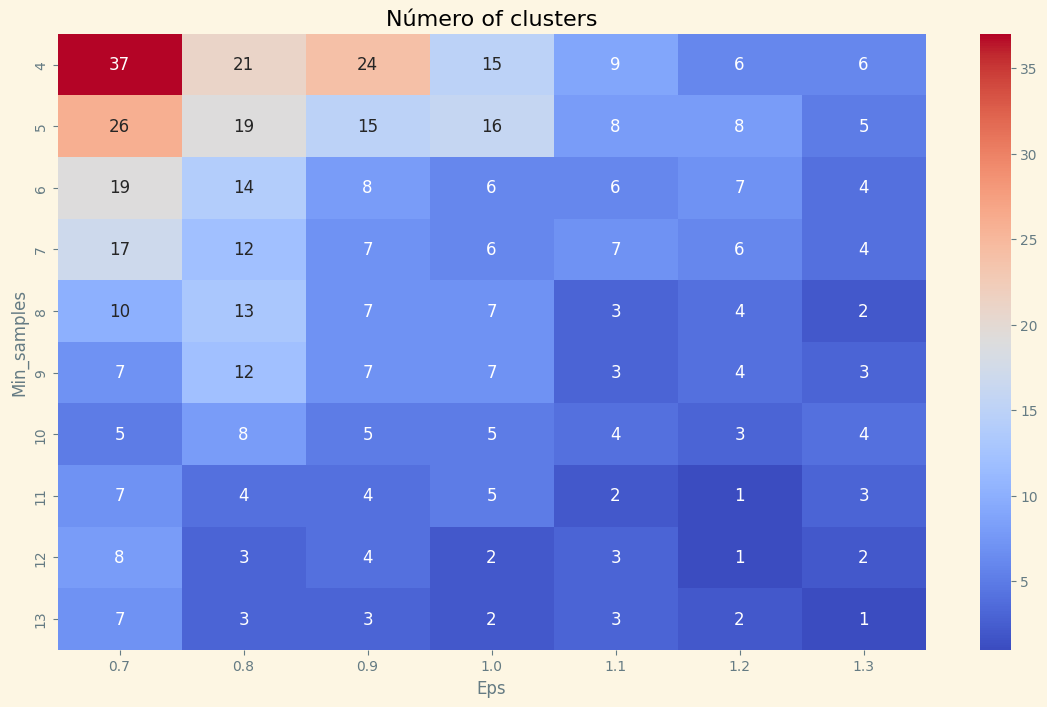

In [86]:
pivot_clusters = pd.pivot_table(dbscan_configs_df, values="num_clusters", index="Min_samples", columns="Eps")

fig, ax = plt.subplots(figsize=(14,8))
sns.heatmap(pivot_clusters, annot=True, annot_kws={"size": 12}, cmap="coolwarm", ax=ax)
ax.set_title("Número of clusters")
plt.show()

El heatmap ilustra la variabilidad en el número de clusters generados por las diferentes combinaciones de `eps` y `min_samples`. El reto radica en identificar una configuración que produzca un número de clusters adecuado para revelar las estructuras subyacentes en los datos, evitando tanto la sobresimplificación con muy pocos clusters como la fragmentación excesiva con demasiados.

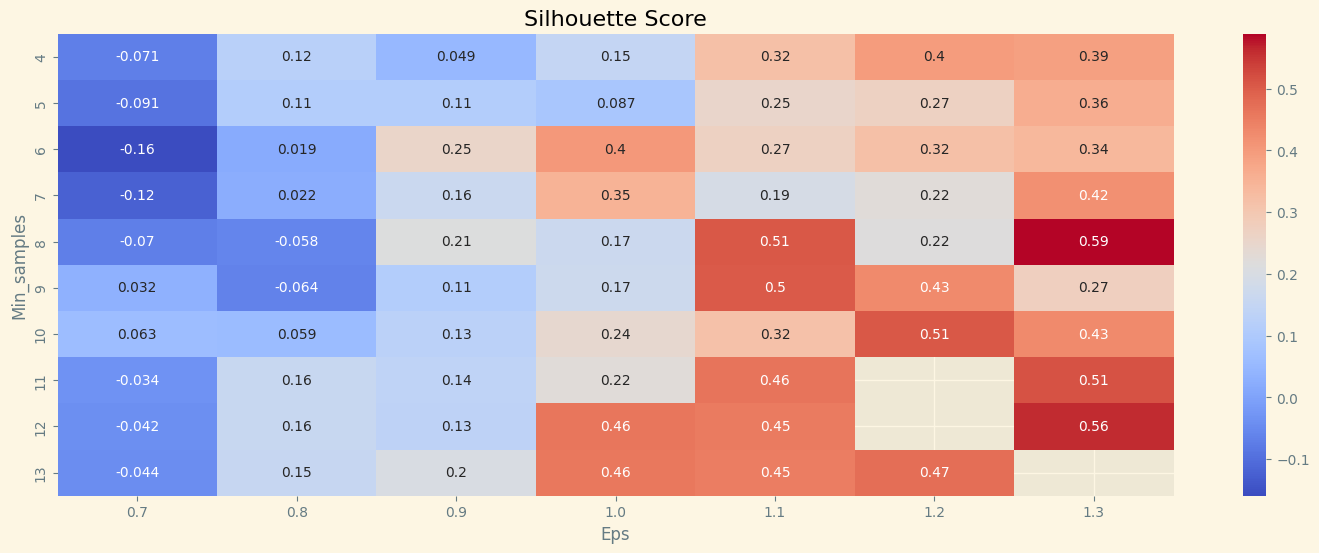

In [87]:
pivot_score = pd.pivot_table(dbscan_configs_df, values="sil_score", index="Min_samples", columns="Eps")

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_score, annot=True, annot_kws={"size": 10}, cmap="coolwarm", ax=ax)
ax.set_title("Silhouette Score")
plt.show()

Este heatmap muestra el `Silhouette Score` correspondiente a cada configuración de `eps` y `min_samples`. La interpretación de estos valores es crucial para evaluar la calidad del clustering:

* Un valor cercano a 1 indica que los puntos están bien agrupados dentro de sus respectivos clusters.

* Un valor cercano a 0 sugiere que los puntos se encuentran en el límite entre dos clusters.

* Un valor negativo señala que los puntos podrían estar mal agrupados.

El desafío consiste en identificar las configuraciones de eps y min_samples que no solo produzcan un Silhouette Score cercano a 1, sino que también generen un número razonable de clusters, complementando así el análisis del heatmap anterior.

*NOTA: las combinaciones `sin score` corresponden a configuraciones que han generado un único cluster (además del cluster de ruido), por lo que el cálculo del Silhouette Score no fue realizado.*

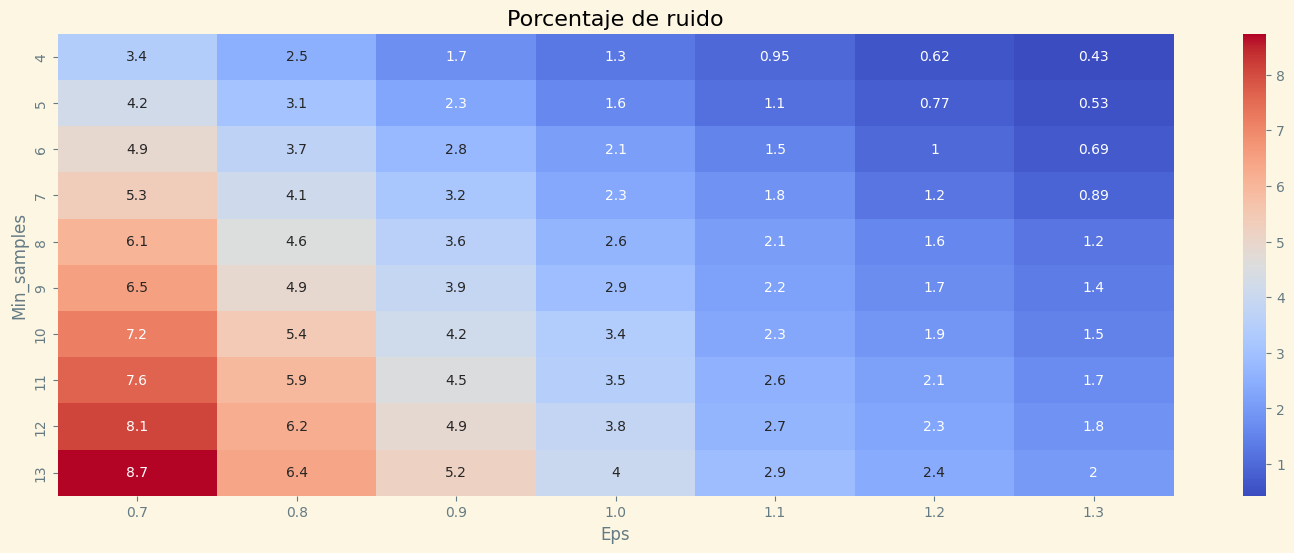

In [88]:
pivot_noise = pd.pivot_table(dbscan_configs_df, values="perc_noise", index="Min_samples", columns="Eps")

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_noise, annot=True, annot_kws={"size": 10}, cmap="coolwarm", ax=ax)
ax.set_title("Porcentaje de ruido")
plt.show()

Este heatmap muestra el `Porcentaje de ruido` generado por cada configuración de `eps` y `min_samples`. Si bien un cierto nivel de ruido es natural en un clustering saludable, este no debería superar ni eclipsar a los clusters generados.

Los porcentajes de ruido están representados en una escala de 0 a 100.

###### Conclusión de la evaluación gráfica

Para encontrar la intersección de los conjuntos `Número de clusters`, `Silhouette Score` y `Porcentaje de ruido`, hay que identificar los rangos de `min_samples` y `eps` que se solapan en los tres criterios.

**Intersección de min_samples**:

* Número de clusters: 5 a 13.

* Silhouette score: 4 a 13.

* Ruido: 4 a 13, paso de 1.

* Intersección: **5 a 13**.

**Intersección de eps**:

* Número de clusters: 0.7 a 1.2.

* Silhouette score: 0.9 a 1.3.

* Ruido: 0.7 a 1.3.

* Intersección: **0.9 a 1.2**.

**Resultado de la intersección**:

**min_samples: 5 a 13**

**eps: 0.9 a 1.2**

##### Evaluación calculada de mejores combinaciones

Se analizan computacionalmente aquellas configuraciones a fin de determinar la óptima.

###### Determinación del mejor cluster

El clustering óptimo será aquel que cumpla las siguientes condiciones:

* Existen más de 2 clusters (además del cluster de ruido)

* El Silhouette score es superior a 0.3

* La diferencia entre la cantidad de puntos en el cluster principal (Cluster 0) y el siguiente (Cluster 1) es la menor. (Esto se debe a que la distribución de los puntos es muy densa)

In [89]:
# Calcular el tamaño de los clusters (Cantidad de puntos en cada cluster)

# Almacenar el tamaño de los clusters
cluster_sizes = []

# La columna 'labels' contiene las etiquetas de los clusters para cada configuración
for labels in dbscan_configs_df['labels']:
    # Contar el número de puntos en cada cluster, excluyendo el ruido (-1)
    unique, counts = np.unique(labels, return_counts=True)
    cluster_info = dict(zip(unique, counts))
    
    # Remover el ruido de los clusters
    if -1 in cluster_info:
        del cluster_info[-1]
    
    # Ordenar los tamaños de los clusters en orden descendente
    sorted_cluster_sizes = sorted(cluster_info.values(), reverse=True)
    
    # Agregar los tamaños de los clusters a la lista
    cluster_sizes.append(sorted_cluster_sizes)

# Añadir la columna `cluster_sizes` al DataFrame
dbscan_configs_df['cluster_sizes'] = cluster_sizes
dbscan_configs_df

,Eps,Min_samples,num_clusters,num_noise,perc_noise,sil_score,labels,cluster_sizes
0,0.7,4,37,535,3.429707,-0.070712,"[0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0,...","[14775, 61, 15, 15, 14, 14, 11, 10, 9, 8, 7, 7..."
1,0.7,5,26,655,4.198987,-0.091152,"[0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0,...","[14699, 36, 23, 23, 14, 11, 11, 11, 10, 10, 9,..."
2,0.7,6,19,762,4.884929,-0.159246,"[0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0,...","[14637, 25, 24, 23, 22, 12, 10, 10, 10, 8, 7, ..."
3,0.7,7,17,831,5.327265,-0.122921,"[0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0,...","[14603, 24, 23, 17, 11, 10, 10, 9, 8, 7, 7, 7,..."
4,0.7,8,10,944,6.051670,-0.069904,"[0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 2, 0, 0,...","[14552, 21, 17, 14, 10, 9, 9, 9, 8, 6]"
...,...,...,...,...,...,...,...,...
65,1.3,9,3,213,1.365472,0.274488,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[15350, 31, 5]"
66,1.3,10,4,232,1.487275,0.430796,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[15337, 17, 8, 5]"
67,1.3,11,3,262,1.679595,0.513404,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[15315, 12, 10]"
68,1.3,12,2,281,1.801398,0.562555,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[15306, 12]"


In [90]:
# Obtener los clusters filtrados y ordenados

def cluster_size_difference(cluster_sizes):
    if len(cluster_sizes) > 1:  # Asegurarse de que haya al menos dos clusters
        sorted_sizes = sorted(cluster_sizes, reverse=True)
        return sorted_sizes[0], sorted_sizes[1], sorted_sizes[0] - sorted_sizes[1]
    elif len(cluster_sizes) == 1:
        return cluster_sizes[0], 0, cluster_sizes[0]  # Si hay solo un cluster, el segundo es 0 y la diferencia es el tamaño del único cluster
    return 0, 0, 0  # Si no hay clusters válidos, todo es 0


# Aplicar la función para obtener los tamaños de Cluster[0] y Cluster[1] y la diferencia entre ellos
dbscan_configs_df[['Cluster_0', 'Cluster_1', 'Cluster_size_diff']] = dbscan_configs_df['cluster_sizes'].apply(
    lambda x: pd.Series(cluster_size_difference(x))
)

# Filtrar las configuraciones válidas
valid_configs_df = dbscan_configs_df[
    (dbscan_configs_df['num_clusters'] > 2) &
    (dbscan_configs_df['sil_score'] > 0.3)
]

# Ordenar por diferencia de tamaño (ascendente), luego por perc_noise (ascendente), y por sil_score (descendente)
sorted_results_df = valid_configs_df.sort_values(
    by=['Cluster_size_diff', 'perc_noise', 'sil_score'],
    ascending=[True, True, False]
)

# Mostrar las configuraciones válidas con los tamaños de Cluster[0], Cluster[1] y la diferencia
print("Configuraciones válidas:")
print(sorted_results_df[['Eps', 'Min_samples', 'num_clusters', 'perc_noise', 'sil_score', 'Cluster_size_diff']])


Configuraciones válidas:
    Eps  Min_samples  num_clusters  perc_noise  sil_score  Cluster_size_diff
49  1.1           13             3    2.865568   0.450375              15091
48  1.1           12             3    2.660427   0.452391              15113
33  1.0            7             6    2.339894   0.349613              15177
46  1.1           10             4    2.307840   0.317027              15203
32  1.0            6             6    2.115520   0.402147              15228
45  1.1            9             3    2.179627   0.504282              15230
44  1.1            8             3    2.064235   0.505089              15248
56  1.2           10             3    1.897558   0.507156              15274
55  1.2            9             4    1.724470   0.429199              15285
67  1.3           11             3    1.679595   0.513404              15303
66  1.3           10             4    1.487275   0.430796              15320
52  1.2            6             7    1.012885   0.

##### Visualización de configuración óptima

En base a los cálculos realizados en el paso anterior, se visualiza la configuración óptima de `eps` y `min_samples`.

In [91]:
# Valores optimos de eps y min_samples
eps_optimo = sorted_results_df.iloc[0]['Eps']
min_samples_optimo = sorted_results_df.iloc[0]['Min_samples']

dbs_clustering = DBSCAN(eps=eps_optimo, min_samples=min_samples_optimo).fit(component_df)

dbs_clustered = component_df.copy()
dbs_clustered.loc[:,'Cluster'] = dbs_clustering.labels_ # append labels

In [92]:
dbscan_cluster_sizes = dbs_clustered.groupby('Cluster').size().to_frame()
dbscan_cluster_sizes.columns = ['DBSCAN_size']
dbscan_cluster_sizes

,DBSCAN_size
Cluster,
-1,447
0,15115
1,24
2,13


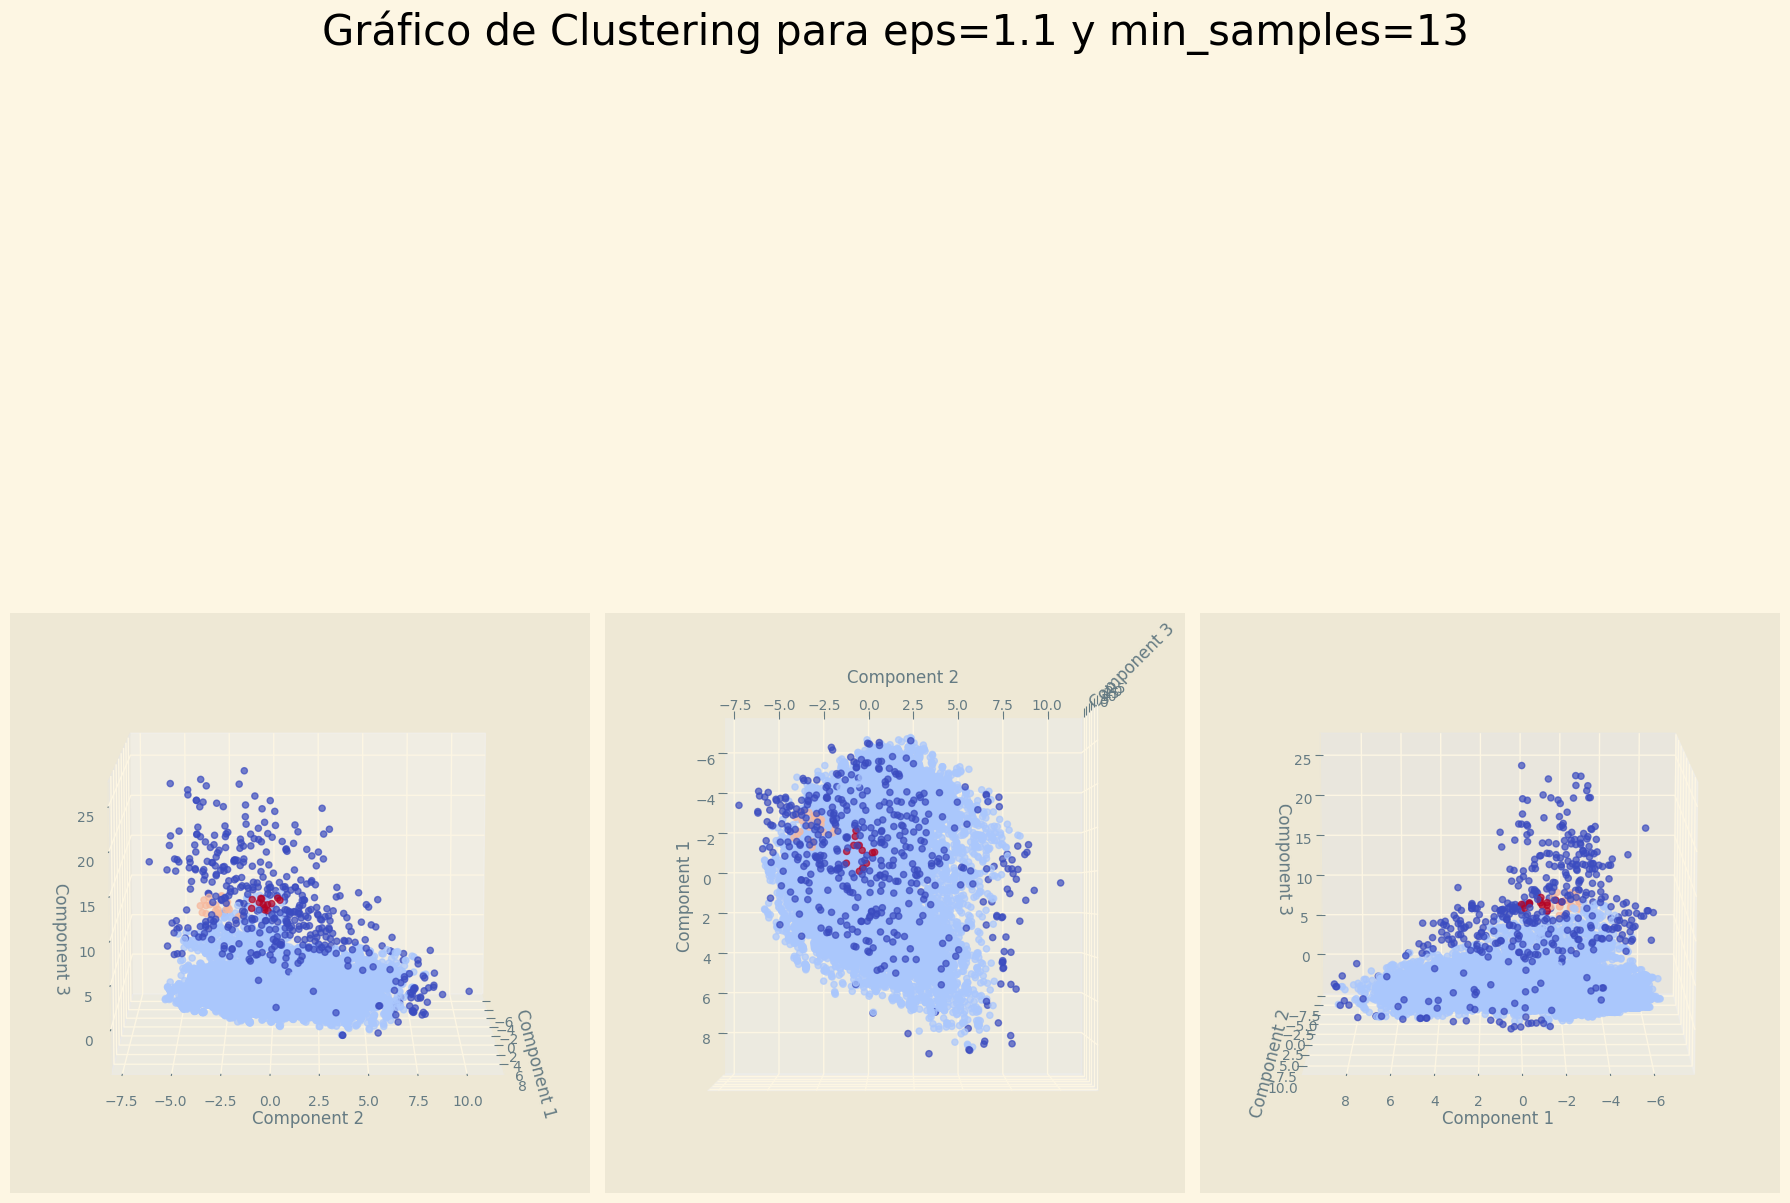

In [93]:
# Características principales
caract_1 = 'Component 1'
caract_2 = 'Component 2'
caract_3 = 'Component 3'

# Ángulos de visualización
angles = [(10, 0), (90, 0), (10, 90)]  

fig, axes = plt.subplots(1, 3, figsize=(18, 18), subplot_kw={'projection': '3d'})

for j, (elev, azim) in enumerate(angles):
    ax = axes[j]
    scatter = ax.scatter(dbs_clustered[caract_1], dbs_clustered[caract_2], dbs_clustered[caract_3], 
                            c=dbs_clustered['Cluster'], cmap='coolwarm', marker='o', alpha=0.7)
    
    # Configurar los ángulos de visualización
    ax.view_init(elev=elev, azim=azim)
    
    # Etiquetas de los ejes
    ax.set_xlabel(caract_1)
    ax.set_ylabel(caract_2)
    ax.set_zlabel(caract_3)
    
        
fig.suptitle(f'Gráfico de Clustering para eps={eps_optimo} y min_samples={min_samples_optimo}', fontsize=30)
plt.tight_layout()
plt.show()

##### Conclusión

DBSCAN ha sido un desafío para el dataset. La alta densidad de sus datos ha dificultado la determinación de `eps` y `min_values`, los cuales requirieron más de 10 iteraciones y un alto costo de procesamiento.

La configuración óptima de estos valores presenta un puñado de clusters, con una predominancia excesiva del cluster principal (Cluster 0) lo que dificulta significativamente la interpretación y la identificación de las características clave que influyen en este clustering dentro del dataset original. 

Esto sugiere que DBSCAN, aunque efectivo en otros contextos, no es la mejor opción para este tipo de datos, y sería recomendable explorar otros métodos de clustering o enfoques alternativos para obtener resultados más interpretables y útiles.